# Imports

In [ ]:
!pip install transformers
!pip install emoji
!pip install sentencepiece
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=2a43f6813baa18a012711d241017a5450f39c2c565c26b0d61bfbd3f90aaa414
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import plotly.express as px
import torch
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm
# from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import emoji
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModel, AutoConfig
from sklearn.metrics import classification_report
from transformers.modeling_outputs import TokenClassifierOutput, SequenceClassifierOutput
from transformers import AdamW, get_scheduler
from datasets import load_metric, Dataset
from statistics import mean

# Mounting Drive for Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive/NLP_Project'

/content/drive/MyDrive/NLP_Project


# utils

In [ ]:
def read_data(file_path = "train.csv"):
  df = pd.read_csv(file_path)
  df['len'] = df['text'].apply(lambda x: len(x))
  df['label'] = df['label'].astype('float32')
#   df['normalized_label'] = df['label'].apply(lambda x: (x-1)/5)
  return df

def filter_tweet_language(df, language = "English"):
  return df[df['language']==language]

def filter_tweet_intimacy(df, lower_bound = 1, upper_bound = 5):
  return df.loc[(df['label'] >= lower_bound) & (df['label'] <= upper_bound)]

def train_val_test_split(df, train_portion = 0.8, val_portion = 0.1, test_portion = 0.1):
    df_train, df_val, df_test, _ = np.split(df.sample(frac=1, random_state=42), [int(train_portion * len(df)), int((train_portion + val_portion) * len(df)), int((train_portion + val_portion + test_portion) * len(df))])
    return df_train, df_val, df_test

def extract_emojis(df):
    emojis_list = list()
    for s in df['text']:
        emojis_in_text = emoji.distinct_emoji_list(s)
        if len(emojis_in_text)>0:
            emojis_list.extend(emojis_in_text)
    return list(set(emojis_list))

# HuggingFace Models

## hyperparameters

In [ ]:
EPOCHS = 5
BATCH_SIZE = 32
PATH_TO_SAVE = "./checkpoint"

## creating dataset

In [ ]:
class RegressionIntimacyDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.all_data = df
        self.tokenizer = tokenizer
        
        # tokenized texts of our dataset
        self.texts = [self.tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt") 
                                for text in self.all_data['text']]

        # intimacy scores
        scaler = MinMaxScaler()
        self.labels = scaler.fit_transform(self.all_data['label'].to_numpy().reshape(-1, 1))
    
    def classes(self,):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    
    def get_max_setntence_len(self):
        # get length of longest sentence in our dataset
        return max(self.all_data['len'])
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)
        
        return batch_texts, batch_labels




In [ ]:
MODEL = "cardiffnlp/twitter-xlm-roberta-base"

In [ ]:
# tokenizer for tokenization of texts
# bert_base_uncased_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # cased or uncased?
xlmt_tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)


In [ ]:
df = read_data()
intim_dataset = RegressionIntimacyDataset(df, xlmt_tokenizer)
print(len(intim_dataset.labels))

9491


In [ ]:
df['label']

0       1.8
1       1.0
2       1.0
3       1.6
4       1.6
       ... 
9486    1.0
9487    2.0
9488    3.8
9489    1.8
9490    1.6
Name: label, Length: 9491, dtype: float32

## model definition

In [ ]:
xlmt_model = AutoModel.from_pretrained("cardiffnlp/twitter-xlm-roberta-base")

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this mode

In [ ]:
for name, param in xlmt_model.named_parameters():
    param.requires_grad = False
    if name == 'pooler.dense.weight' or name == 'pooler.dense.bias':
        param.requires_grad = True
    print(name, param.requires_grad)

embeddings.word_embeddings.weight False
embeddings.position_embeddings.weight False
embeddings.token_type_embeddings.weight False
embeddings.LayerNorm.weight False
embeddings.LayerNorm.bias False
encoder.layer.0.attention.self.query.weight False
encoder.layer.0.attention.self.query.bias False
encoder.layer.0.attention.self.key.weight False
encoder.layer.0.attention.self.key.bias False
encoder.layer.0.attention.self.value.weight False
encoder.layer.0.attention.self.value.bias False
encoder.layer.0.attention.output.dense.weight False
encoder.layer.0.attention.output.dense.bias False
encoder.layer.0.attention.output.LayerNorm.weight False
encoder.layer.0.attention.output.LayerNorm.bias False
encoder.layer.0.intermediate.dense.weight False
encoder.layer.0.intermediate.dense.bias False
encoder.layer.0.output.dense.weight False
encoder.layer.0.output.dense.bias False
encoder.layer.0.output.LayerNorm.weight False
encoder.layer.0.output.LayerNorm.bias False
encoder.layer.1.attention.self.query

In [ ]:
class XLMTRegressor(nn.Module):
    def __init__(self, model, hidden_count = 20, dropout = 0.2):
        super(XLMTRegressor, self).__init__()

        self.xlmt = model
        self.linear = nn.Linear(768, hidden_count)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.regression = nn.Linear(hidden_count, 1)

    def forward(self, input_ids = None, attention_mask = None, labels = None):
        encoding_output = self.xlmt(input_ids = input_ids, attention_mask = attention_mask)
        # https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.BaseModelOutputWithPooling
        linear_output = self.linear(encoding_output[1])
        relu_output = self.relu(linear_output)
        dropout_output = self.dropout(relu_output)
        final_output = self.regression(dropout_output)

        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(final_output, labels)
        
        return SequenceClassifierOutput(loss = loss, logits = final_output, hidden_states = encoding_output.hidden_states, attentions = encoding_output.attentions)



## train model

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = RegressionIntimacyDataset(train_data, xlmt_tokenizer), RegressionIntimacyDataset(val_data, xlmt_tokenizer)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size = BATCH_SIZE, shuffle = True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = AdamW(model.parameters(), lr = learning_rate)

    if use_cuda:
        model = model.cuda()

    for epoch_num in range(epochs):
        model.train()

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            outputs = model(input_id, mask, train_label)

            loss = outputs.loss
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        
        torch.save(model.state_dict(), f'{PATH_TO_SAVE}_{epoch_num}')


        model.eval()
        eval_losses = []
        for val_input, val_label in tqdm(val_dataloader):
            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)

            with torch.no_grad():
                outputs = model(input_id, mask, val_label)
            
            model_pred = outputs.logits
            eval_losses.append(outputs.loss.item())

        print(f'loss = {mean(eval_losses)}')
                
EPOCHS = 5
model = XLMTRegressor(xlmt_model)
LR = 1e-3

df_train, df_val, df_test = train_val_test_split(df)
train(model, df_train, df_val, LR, EPOCHS)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


loss = 0.03679414385308822


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


loss = 0.03377731361736854


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


loss = 0.03337364811450243


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


loss = 0.03205319847911596


100%|██████████| 30/30 [00:28<00:00,  1.05it/s]

loss = 0.032118543547888595


## evaluate

In [ ]:
def evaluate(model, test_data):
    test = RegressionIntimacyDataset(test_data, xlmt_tokenizer)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    model.eval()
    with torch.no_grad():
        test_losses = []
        for test_input, test_label in tqdm(test_dataloader):
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            outputs = model(input_id, mask, test_label)

            model_pred = outputs.logits
            test_losses.append(outputs.loss.item())
    
    print(f'loss = {mean(test_losses)}')
    
evaluate(model, df_test)

100%|██████████| 475/475 [00:29<00:00, 16.14it/s]


loss = 0.030576393889557373


## evaluation on test data codalab

In [ ]:
PATH_FOR_READ = './checkpoint'

In [ ]:
def read_test_data(file_path = "semeval_test.csv"):
  df = pd.read_csv(file_path)
#   df['len'] = df['text'].apply(lambda x: len(x))
#   df['label'] = df['label'].astype('float32')
#   df['normalized_label'] = df['label'].apply(lambda x: (x-1)/5)
  return df

In [ ]:
class TestRegressionIntimacyDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.all_data = df
        self.tokenizer = tokenizer
        
        # tokenized texts of our dataset
        self.texts = [self.tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt") 
                                for text in self.all_data['text']]
    
    def __len__(self):
        return len(self.all_data)
    
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        
        return batch_texts


In [ ]:
MODEL = "cardiffnlp/twitter-xlm-roberta-base"
xlmt_tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

In [ ]:
xlmt_model = AutoModel.from_pretrained("cardiffnlp/twitter-xlm-roberta-base")

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this mode

In [ ]:
# for name, param in xlmt_model.named_parameters():
#     param.requires_grad = False

In [ ]:
model = XLMTRegressor(xlmt_model)
model.load_state_dict(torch.load(f'{PATH_FOR_READ}_{EPOCHS-1}'))
# model.load_state_dict(torch.load(f'{PATH_FOR_READ}_{EPOCHS-1}', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
def predict(model, test_data):
    test = TestRegressionIntimacyDataset(test_data, xlmt_tokenizer)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=32)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    model_predictions = []
    model.eval()
    with torch.no_grad():
        for test_input in tqdm(test_dataloader):
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            outputs = model(input_id, mask)
            model_pred = outputs.logits
            model_predictions.append(model_pred)
    return model_predictions


In [ ]:
df_coda = read_test_data("train.csv")    
# df_coda = read_test_data("semeval_test.csv")    
outputs = predict(model, df_coda)

100%|██████████| 297/297 [04:42<00:00,  1.05it/s]


In [ ]:
flat_predictions = [item.cpu().numpy()[0] for sublist in outputs for item in sublist]

In [ ]:
min_flat = min(flat_predictions)
max_flat = max(flat_predictions)

In [ ]:
print(len(flat_predictions))

9491


In [ ]:
df_coda['predictions'] = flat_predictions
df_coda['predictions'] = df_coda['predictions'].apply(lambda x: (x - min_flat) * 4 / (max_flat - min_flat) + 1)
df_coda.to_csv('results.csv')

In [ ]:
df_coda['predictions'].argmax()

12021

In [ ]:
df_coda['predictions'].min()

3.261665493249893

In [ ]:
print(df_coda['predictions'].argmin())
print(df_coda['text'][14])
print(df_coda['language'][14])


14
#1Ene 1942 se firma la declaración de la Naciones Unidas. #60AñosDeRevoluciónCubana #Feliz2019 http
Spanish


In [ ]:
print(df_coda['text'][12021])
print(df_coda['language'][12021])

@user ily bestie💞
Dutch


In [ ]:
# find subtraction
sub = df_coda['predictions'] - df_coda['label']
print(abs(sub).argmax())

2439


In [ ]:
print(df_coda['text'][2439])
print(df_coda['language'][2439])

Que empiece el fin de cojedera. Empezamos con un gang Bang. Activos un paso al frente
Spanish


## train with Huggingface API

In [ ]:
class HuggingfaceRegressionIntimacyDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.all_data = df
        self.tokenizer = tokenizer
        
        # tokenized texts of our dataset
        # self.texts = [self.tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt") 
        #                         for text in self.all_data['text']]
        self.texts = self.all_data['text'].to_list()
        self.encodings = self.tokenizer(self.texts, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

        # intimacy scores
        scaler = MinMaxScaler()
        self.labels = scaler.fit_transform(self.all_data['label'].to_numpy().reshape(-1, 1))
    
    def classes(self,):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_max_setntence_len(self):
        # get length of longest sentence in our dataset
        return max(self.all_data['len'])
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        
        return item


In [ ]:
training_args = TrainingArguments(
    output_dir = './results',                   # output directory
    num_train_epochs = EPOCHS,                  # total number of training epochs
    per_device_train_batch_size = BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size = BATCH_SIZE,    # batch size for evaluation
    warmup_steps = 100,                         # number of warmup steps for learning rate scheduler
    weight_decay = 0.01,                        # strength of weight decay
    logging_dir = './logs',                     # directory for storing logs
    logging_steps = 10,                         # when to print log
    save_strategy = 'no',
    load_best_model_at_end = True,              # load or not best model at the end
)

In [ ]:
model = XLMTRegressor(xlmt_model)

df_train, df_val, df_test = train_val_test_split(df)

train_dataset = HuggingfaceRegressionIntimacyDataset(df_train, xlmt_tokenizer)
val_dataset =  HuggingfaceRegressionIntimacyDataset(df_val, xlmt_tokenizer)
test_dataset = HuggingfaceRegressionIntimacyDataset(df_test, xlmt_tokenizer)

# train_dataloader = torch.utils.data.DataLoader(train, batch_size = 2, shuffle = True)
# val_dataloader = torch.utils.data.DataLoader(val, batch_size = 2, shuffle = True)


In [ ]:
train_dataset.encodings

{'input_ids': tensor([[     0,   1818,   2270,  ...,      1,      1,      1],
        [     0,   5685,   7632,  ...,      1,      1,      1],
        [     0,   1374,  24447,  ...,      1,      1,      1],
        ...,
        [     0,   1027,    163,  ...,      1,      1,      1],
        [     0,   1374, 118571,  ...,      1,      1,      1],
        [     0,   6376, 239208,  ...,      1,      1,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
trainer = Trainer(
    model = model,                              # the instantiated 🤗 Transformers model to be trained
    args = training_args,                       # training arguments, defined above
    train_dataset = train_dataset,              # training dataset
    eval_dataset = val_dataset                  # evaluation dataset
)

trainer.train()

AttributeError: ignored

# Bert base

## Dataset class

In [ ]:
# 15 Epochs
# learning rate 0.001
# batch size 128
# optimizer AdamW

In [ ]:
# tokenizer for tokenization of texts
bert_base_uncased_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # cased or uncased?


class IntimacyBertBaseUncasedDataset(Dataset):
    def __init__(self, df):
        self.all_data = df

        # unique intimacy scores exist in our datasets
        self.unique_scores = sorted(self.all_data['label'].unique())

        # dictionary for mapping intimacy scores to labels
        self.scores_to_labels = dict()
        for i, item in enumerate(self.unique_scores):
            self.scores_to_labels[item] = i
        

        # tokenized texts of our dataset
        self.texts = [bert_base_uncased_tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt") 
                                for text in self.all_data['text']]

        # labels of each text in our dataset based on intimacy scores
        # self.labels = [self.scores_to_labels[label] for label in self.all_data['label']]
        scaler = MinMaxScaler()
        self.labels = scaler.fit_transform(self.all_data['label'].to_numpy().reshape(-1, 1))
    
    def classes(self,):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    
    def get_max_setntence_len(self):
        # get length of longest sentence in our dataset
        return max(self.all_data['len'])
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)
        
        return batch_texts, batch_labels


class RegressionIntimacyBertBaseUncasedDataset(Dataset):
    def __init__(self, df):
        self.all_data = df
        
        # dictionary for mapping intimacy scores to labels
        self.scores_to_labels = dict()
        for i, item in enumerate(self.unique_scores):
            self.scores_to_labels[item] = i
        

        # tokenized texts of our dataset
        self.texts = [bert_base_uncased_tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt") 
                                for text in self.all_data['text']]

        # intimacy scores
        scaler = MinMaxScaler()
        self.labels = scaler.fit_transform(self.all_data['label'].to_numpy().reshape(-1, 1))
    
    def classes(self,):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]
    
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])
    
    def get_max_setntence_len(self):
        # get length of longest sentence in our dataset
        return max(self.all_data['len'])
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)
        
        return batch_texts, batch_labels




In [ ]:
df = read_data()
intim_dataset = IntimacyDataset(df)
print(intim_dataset.labels)

[9, 0, 0, 6, 6, 2, 1, 4, 20, 0, 6, 3, 30, 34, 16, 0, 20, 16, 4, 9, 15, 2, 16, 1, 0, 15, 4, 0, 8, 0, 2, 5, 1, 30, 0, 11, 19, 2, 12, 3, 1, 6, 10, 5, 4, 0, 10, 8, 8, 0, 12, 0, 1, 14, 2, 11, 9, 0, 10, 0, 0, 2, 0, 16, 9, 10, 20, 4, 6, 22, 0, 6, 20, 6, 6, 21, 13, 9, 0, 8, 0, 12, 0, 0, 0, 1, 6, 19, 10, 20, 1, 10, 10, 10, 0, 20, 40, 2, 2, 6, 4, 4, 9, 21, 0, 16, 0, 1, 1, 14, 10, 10, 4, 22, 9, 6, 0, 3, 15, 8, 10, 1, 1, 6, 11, 10, 10, 2, 1, 4, 20, 11, 11, 2, 11, 9, 10, 22, 15, 0, 10, 14, 1, 2, 0, 11, 9, 3, 22, 6, 21, 9, 19, 9, 1, 18, 5, 4, 1, 8, 22, 0, 4, 11, 6, 10, 0, 8, 29, 6, 4, 11, 0, 0, 6, 27, 9, 6, 8, 5, 5, 30, 20, 4, 9, 7, 1, 6, 10, 1, 2, 18, 0, 9, 26, 10, 30, 14, 21, 9, 0, 11, 0, 25, 1, 15, 5, 23, 9, 14, 0, 2, 6, 13, 6, 10, 21, 18, 2, 8, 12, 11, 11, 8, 24, 4, 0, 9, 1, 19, 10, 0, 25, 29, 0, 11, 0, 0, 10, 0, 0, 0, 0, 10, 1, 6, 0, 10, 0, 6, 0, 6, 20, 0, 0, 20, 10, 0, 19, 0, 6, 10, 10, 18, 0, 30, 0, 11, 10, 6, 10, 8, 11, 19, 1, 2, 0, 0, 5, 8, 0, 2, 4, 15, 18, 20, 4, 10, 11, 4, 0, 0, 4, 0, 0, 

In [ ]:
len(intim_dataset.scores_to_labels)

41

In [ ]:
# dataloader = DataLoader(intim_dataset, batch_size = 64, shuffle = True, num_workers = 0)

# for i_batch, sample_batched in enumerate(dataloader):
#     print(i_batch, sample_batched[0], sample_batched[1])

## Defining Model

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, n_class, dropout = 0.5):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, n_class)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids = input_id, attention_mask = mask,return_dict = False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

## Training Loop

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = IntimacyDataset(train_data), IntimacyDataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size = 2, shuffle = True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size = 2, shuffle = True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim = 1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim = 1) == val_label).sum().item()
                total_acc_val += acc
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                
EPOCHS = 5
model = BertClassifier(41) # len(intim_dataset.scores_to_labels)
LR = 1e-6

df_train, df_val, df_test = train_val_test_split(df)
train(model, df_train, df_val, LR, EPOCHS)

## Evaluate Model

In [ ]:
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

# scratchpad

In [ ]:
df = read_data()
print(df.head())

print(max(df['len']))
print(df['text'].iloc[0])
print(df['label'].dtype)

vc = df['label'].value_counts()
u = df['label'].unique()
u = sorted(u)
classes = dict()
for i, item in enumerate(u):
    classes[item] = i

print(classes)


print(len(df['label'].value_counts())) # number of labels
print(df['label'].value_counts()) # number of data for each label
df.groupby(['label']).size().plot.bar() # plot distribution for labels
print("************************")
print(df.groupby(['label']).size())


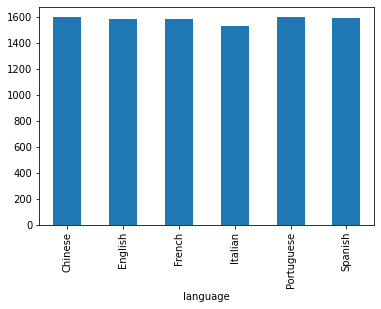

In [ ]:
df.groupby(['language']).size().plot.bar()

In [ ]:
print(len(df))
english_tweets = filter_tweet_language(df)
print(len(english_tweets))
aa = filter_tweet_intimacy(df,4.25,4.3)

9491
1587


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=1f8d8c0b663b421454e55037072a02d82171967a962346ac12b89a97a46894d0
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [ ]:
len(extract_emojis(df))


513

In [ ]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def get_embedding(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    features = model(**encoded_input)
    features = features[0].detach().numpy() 
    features_mean = np.mean(features[0], axis=0) 
    return features_mean

query = "Acabo de pedir pollo frito 🐣" #spanish

tweets = ["We had a great time! ⚽️", # english
          "We hebben een geweldige tijd gehad! ⛩", # dutch
          "Nous avons passé un bon moment! 🎥", # french
          "Ci siamo divertiti! 🍝"] # italian

d = defaultdict(int)
for tweet in tweets:
    sim = 1-cosine(get_embedding(query),get_embedding(tweet))
    d[tweet] = sim
    
print('Most similar to: ',query)
print('----------------------------------------')
for idx,x in enumerate(sorted(d.items(), key=lambda x:x[1], reverse=True)):
  print(idx+1,x[0])

In [ ]:
df_train, df_val, df_test = train_val_test_split(df)
train, val = RegressionIntimacyDataset(df_train, xlmt_tokenizer), RegressionIntimacyDataset(df_val, xlmt_tokenizer)
train_dataloader = torch.utils.data.DataLoader(train, batch_size = 2, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size = 2, shuffle = True)

In [ ]:
xlmt = AutoModel.from_pretrained("cardiffnlp/twitter-xlm-roberta-base")


In [ ]:
for inp, lab in train_dataloader:
    print(inp, lab)
    input_ids = inp['input_ids']
    attention_mask = inp['attention_mask']#.squeeze(1)
    print(50*"*")
    print(input_ids.size())
    print(50*"*")
    print(attention_mask.size())


    encoding_output = xlmt(input_ids = input_ids[0], attention_mask = attention_mask[0])
    # print(encoding_output)
    print(50*"*")
    print(encoding_output[1].size())
    break